In this document we are going to apply of the famous customer segmentation practices called RFM model on Amazon sales data
* The sales data include transactions between 03-Jan-2015 and 30-Dec-2018, so we will build this study as if today is 31-Dec-2018 (the day after the last transaction)
* We will consider only the trailing 18 months history


In [1]:
# load CSV data to DateFrame
import pandas as pd
import numpy as np

sales_df = pd.read_csv('data.csv')
sales_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [2]:
# Converting Order Date column to date
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'], dayfirst=True)

In [3]:
# Snapshot date (The hypothetical "Today")
from datetime import datetime, timedelta

last_transaction_date = sales_df["Order Date"].max()
snapshot_date = last_transaction_date + timedelta(days=1)
print('Last Transaction Date :', last_transaction_date)
print('Snapshot Date :', snapshot_date)

Last Transaction Date : 2018-12-30 00:00:00
Snapshot Date : 2018-12-31 00:00:00


In [4]:
# Subset of trailing 18 months sales 
sales_last_18_months = sales_df[sales_df["Order Date"] >= datetime(2018, 12, 30) - timedelta(days=540)]

In [5]:
# Aggregating orders' lines
orders_last_18_months = sales_last_18_months.groupby(['Customer ID','Order ID', 'Order Date'])['Sales'].sum().reset_index()

In [6]:
datamart = orders_last_18_months.groupby("Customer ID").agg(
    recency=("Order Date", lambda x: (snapshot_date - x.max()).days),  # days passed since the last order
    frequency=("Order ID", "count"),                                   # number of orders during the period
    sales_Last_18_M=("Sales", "sum"),                                  # sales generated during the period
).reset_index()
datamart.head()

,Customer ID,recency,frequency,sales_Last_18_M
0,AA-10315,185,1,374.480
1,AA-10375,20,4,737.020
2,AA-10480,260,3,1763.052
3,AA-10645,56,2,304.700
4,AB-10015,416,1,563.940


In [7]:
datamart['R'] = pd.qcut(datamart['recency'], q=4, labels=[4,3,2,1])
datamart['F'] = pd.qcut(datamart['frequency'], q=4, labels=[1,2,3,4])
datamart['M'] = pd.qcut(datamart['sales_Last_18_M'], q=4, labels=[1,2,3,4])
datamart['segment_label'] = datamart['R'].astype(str) + datamart['F'].astype(str) + datamart['M'].astype(str)
datamart['segment_score'] = datamart['R'].astype(int) + datamart['F'].astype(int) + datamart['M'].astype(int)

In [8]:
samples = datamart[['recency','frequency','sales_Last_18_M']].values

In [9]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=1)
km.fit(samples)

KMeans(n_clusters=3, random_state=1)

In [10]:
datamart['cluster'] = km.labels_

In [40]:
customer_cluster_summary = (
    datamart.groupby("cluster").agg(
        Mean_Recency=("recency", "mean"),
        Mean_Frequency=("frequency", "mean"),
        Mean_Monetary=("sales_Last_18_M", "mean"),
        Customer_Count=("Customer ID", "count"),
        Total_Sales=("sales_Last_18_M", "sum"),
        Total_Sales_s=("sales_Last_18_M", lambda x: sum(x / 120)),
    ).round(1)
).reset_index()
customer_cluster_summary

,cluster,Mean_Recency,Mean_Frequency,Mean_Monetary,Customer_Count,Total_Sales,Total_Sales_s
0,0,82.4,4.2,2698.8,189,510072.7,4250.6
1,1,132.4,2.8,658.6,535,352368.5,2936.4
2,2,76.3,5.1,7695.8,29,223177.5,1859.8


In [49]:
r_line = datamart['recency'].mean()
f_line = datamart['frequency'].mean()

# customer_cluster_summary['Mean_Frequency'].mean()

In [58]:
f_line

np.float64(3.2802124833997346)

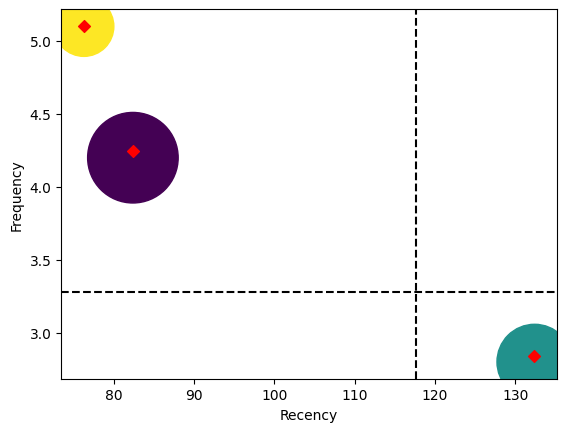

In [73]:
import matplotlib.pyplot as plt

# plt.scatter(data=datamart, x='recency', y='frequency', c='cluster', s='sales_Last_18_M')
# plt.scatter(data=datamart, x='recency', y='frequency', c='cluster')
plt.scatter(data=customer_cluster_summary, x='Mean_Recency', y='Mean_Frequency', s='Total_Sales_s', c='cluster')
plt.scatter(x=km.cluster_centers_[:,0], y=km.cluster_centers_[:,1], marker='D', c='red')
plt.axhline(y=f_line, color='k', linestyle='--', label='Mean='+str(f_line))
plt.axvline(x=r_line, color='k', linestyle='--', label='Mean='+str(r_line))

# plt.legend()
# plt.xlim(0, 150)
# plt.ylim(0, 6)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()